### Phase 1 - Standard 2-means

Use 2-means to cluster the corpus. Use standard cluster measures, such as homogeneity, completeness and Rand index to assess the quality of the cluster. Apply any technique or heuristic you deem useful to improve performance of the classifier (e.g. consider increasing the number of independent executions of 2-means, etc.)

In [439]:
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import random_projection
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.corpus import stopwords

import sys
from time import time
import numpy as np
import nltk

from tqdm import tqdm_notebook

First of all we load the file containing our data and labels and we store it into useful data structures.

In [440]:
dataset = list()
labels = list()

file = open("./corpus.tsv")
for line in file:
    s1 = line.replace("\n", "\t")
    splitted1 = s1.split("\t")
    dataset.append(splitted1[1])  

f_labels = open("./labels.txt")
for line in f_labels:
    s2 = line.replace("\n", "\t")
    splitted2 = s2.split("\t")
    labels.append(splitted2[1])

We now perform stemming over the data in order to make it uniform.

In [441]:
stemmer = SnowballStemmer("english")

for i in tqdm_notebook(range(len(dataset))):
    word_list = word_tokenize(dataset[i]) #the text is transformed into a list of tokens
    stemmed_doc = ""
    for word in word_list:
        stemmed_doc = stemmed_doc + " " + stemmer.stem(word) #a string containing the stemmed text
    dataset[i] = stemmed_doc #every entry is replaced by its stemmed version

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

Now we can proceed by converting our stemmed corpus into tf-idf vectors.

In [442]:
vectorizer = TfidfVectorizer(stop_words='english')
M = vectorizer.fit_transform(dataset)

print("M.shape: ", M.shape)

M.shape:  (5000, 9699)


Now it's time to apply the standard K-means with k=2

In [443]:
km1 = MiniBatchKMeans(n_clusters=2, init="k-means++", max_iter=1000, n_init=40)
t0 = time()
km1.fit(M)
print("done in %0.3fs" % (time() - t0))

done in 0.136s


We can now use some standard measures of cluster quality (sklearn.metrics)

In [444]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km1.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km1.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km1.labels_))
print("Adjusted Rand-Index: %0.3f" % metrics.adjusted_rand_score(labels, km1.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(M, km1.labels_, sample_size=M.shape[0]))

Homogeneity: 0.372
Completeness: 0.409
V-measure: 0.390
Adjusted Rand-Index: 0.360
Silhouette Coefficient: 0.009


### Identification of the most relevant terms for each cluster

In [445]:
centroids1 = km1.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i, end='')
    for ind in centroids1[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: use bottl babi cat potti great work like love just
Cluster 1: dog toy chew love flea ball product tick like frontlin


### Phase 2 - Random projection + 2-means
Apply dimensionality reduction (in particular, you can use the classes from sklearn.random_projection to this purpose) first and 2-means afterwards. Plot performance indices of 2-means as the number of dimensions increases from 100 to a value you deem appropriate (motivate your choice for the upper limit).

In the following box we apply the random projection in order to reduce the dimensions of the matrix M.

In [446]:
target_projection_space = johnson_lindenstrauss_min_dim(n_samples=M.shape[0], eps=0.2)

print("Target Projection Space: ", target_projection_space)

transformer = random_projection.SparseRandomProjection(n_components='auto', eps=0.2);
X = transformer.fit_transform(M)

print("The original data have", M.shape[1], "dimensions/features/terms")
print("The number of documents is still", X.shape[0])
print("The number of dimension has become", X.shape[1])

Target Projection Space:  1965
The original data have 9699 dimensions/features/terms
The number of documents is still 5000
The number of dimension has become 1965


Now we apply the same operation for 2-means as before, but this time over the reduced matrix.

In [447]:
km2 = MiniBatchKMeans(n_clusters=2, init="k-means++", max_iter=1000, n_init=40)
t0 = time()
km2.fit(X)
print("done in %0.3fs" % (time() - t0))

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km2.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km2.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km2.labels_))
print("Adjusted Rand-Index: %0.3f" % metrics.adjusted_rand_score(labels, km2.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km2.labels_, sample_size=M.shape[0]))

done in 0.348s
Homogeneity: 0.080
Completeness: 0.213
V-measure: 0.117
Adjusted Rand-Index: 0.029
Silhouette Coefficient: 0.000


### Phase 3 - SVD + 2-means + wordclouds
Apply SVD before 2-means (with or without projecting data first, depending on whether the size of your data requires this or not). Identify the most important terms for each of the two topics you identified, rendering them in a way that reflects theit relative importance (e.g. use a word cloud).

In [448]:
r = 2
t0 = time()
svd = TruncatedSVD(r)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
Y = lsa.fit_transform(M)
print("done in %fs" % (time() - t0))

done in 0.051059s


In [449]:
print("The original data have", M.shape[1], "dimensions/features/terms")
print("The number of documents is still", Y.shape[0])
print("The number of dimension has become", Y.shape[1])

The original data have 9699 dimensions/features/terms
The number of documents is still 5000
The number of dimension has become 2


In [450]:
km3 = MiniBatchKMeans(n_clusters=2, init="k-means++", max_iter=1000, n_init=40)
t0 = time()
km3.fit(Y)
print("done in %0.3fs" % (time() - t0))

done in 0.050s


In [451]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km3.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km3.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km3.labels_))
print("Adjusted Rand-Index: %0.3f" % metrics.adjusted_rand_score(labels, km3.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Y, km3.labels_, sample_size=Y.shape[0]))

Homogeneity: 0.344
Completeness: 0.348
V-measure: 0.346
Adjusted Rand-Index: 0.419
Silhouette Coefficient: 0.615


In [452]:
original_centroids = svd.inverse_transform(km3.cluster_centers_)
print(original_centroids.shape) ## Just a sanity check
for i in range(original_centroids.shape[0]):
    original_centroids[i] = np.array([abs(x) for x in original_centroids[i]])
svd_centroids = original_centroids.argsort()[:, ::-1]

(2, 9699)


In [453]:
for i in range(2):
    print("Cluster %d:" % i, end='')
    for ind in svd_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: use bottl potti babi easi great work just like veri
Cluster 1: dog toy chew love like product use great veri ball


In the following blocks we are going to extract the relative importance between the terms in order to represent it in a proper way.

In [454]:
doc_c0 = ""
doc_c1 = ""
for i in range(len(km3.labels_)):
    if km3.labels_[i] == 1:
        doc_c1 = doc_c1 + dataset[i]
        
    else:
        doc_c0 = doc_c0 + dataset[i]

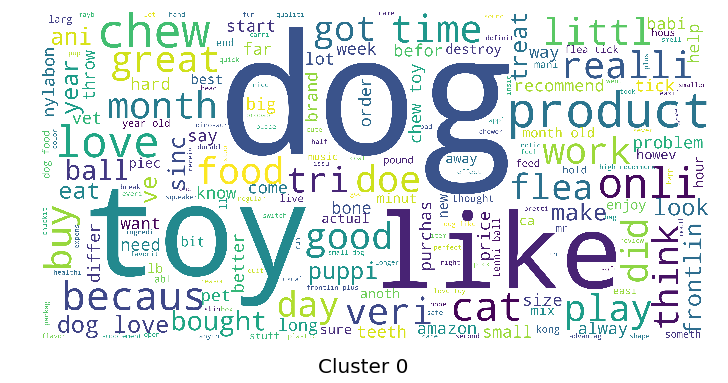

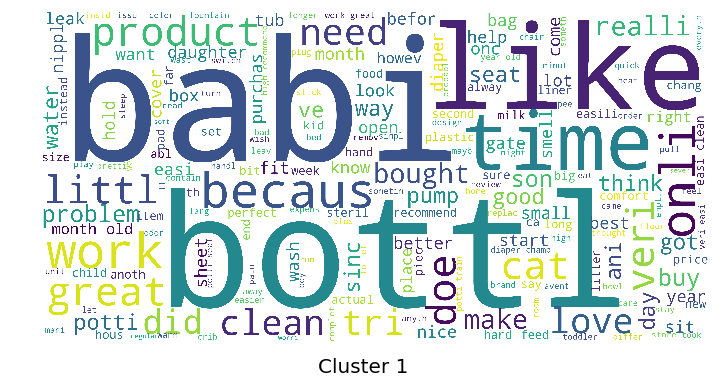

In [455]:
stopwords = set(vectorizer.get_stop_words())
stopwords.add('thing')
stopwords.add('just')
stopwords.add("n't")
stopwords.add('use')

def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=100, 
        scale=10,
        random_state=1
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 12))
    
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.25)
        
    plt.imshow(wordcloud)
    plt.show()
    

show_wordcloud(doc_c1, "Cluster 0")
show_wordcloud(doc_c0, "Cluster 1")